In this approach, the percentage of each unique amino acid, in the different percentiles of the sequences (25%, 50%, etc.) is being considered.

In [1]:
import numpy as np
import pandas as pd

Reading the genome:

In [2]:
from Bio import SeqIO
genome = SeqIO.read('/kaggle/input/grch38-human-genome-dna/Homo_sapiens.GRCh38.dna.chromosome.1.fa','fasta')

In [3]:
print('Length of the sequence: ',len(genome))

Length of the sequence:  248956422


In [4]:
genome_DNA = genome.seq

Finding out the distribution of nucleotides:

In [5]:
count_A = genome_DNA.count('A')
count_G = genome_DNA.count('G')
count_C = genome_DNA.count('C')
count_T = genome_DNA.count('T')

# Calculate the percentages
total_count = len(genome_DNA)
percentage_A = (count_A / total_count) * 100
percentage_G = (count_G / total_count) * 100
percentage_C = (count_C / total_count) * 100
percentage_T = (count_T / total_count) * 100

# Print the percentages
print("Percentage of A: {:.2f}%".format(percentage_A))
print("Percentage of G: {:.2f}%".format(percentage_G))
print("Percentage of C: {:.2f}%".format(percentage_C))
print("Percentage of T: {:.2f}%".format(percentage_T))

Percentage of A: 26.94%
Percentage of G: 19.33%
Percentage of C: 19.30%
Percentage of T: 27.01%


Plotting a graph to show distribution of nucleotides:

<BarContainer object of 4 artists>

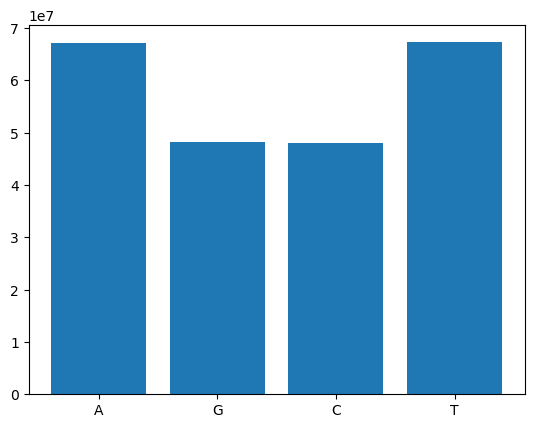

In [6]:
import matplotlib.pyplot as plt

nucleotides = {'A': count_A, 'G': count_G, 'C': count_C, 'T': count_T}

x = list(nucleotides.keys())
y = list(nucleotides.values())

plt.bar(x,y)

Transcribing to find the RNA:

In [7]:
genome_RNA = genome_DNA.transcribe()
print(genome_DNA[:100])
print(genome_RNA[:100])

NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


A graph for RNA:

<BarContainer object of 4 artists>

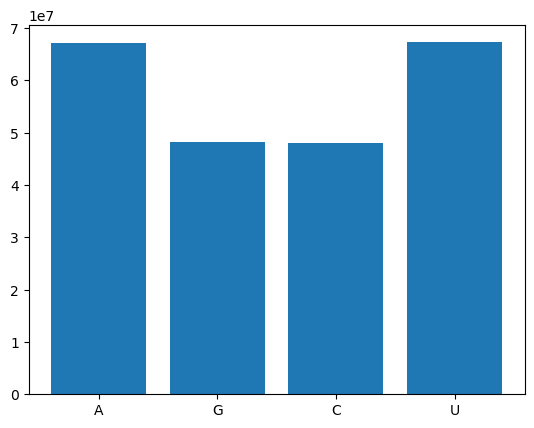

In [8]:
count_U = genome_RNA.count('U')

import matplotlib.pyplot as plt

ribonucleotides = {'A': count_A, 'G': count_G, 'C': count_C, 'U': count_U}

x = list(ribonucleotides.keys())
y = list(ribonucleotides.values())

plt.bar(x,y)

In [10]:
genome_pro = genome_DNA.translate()
print('DNA: ',genome_DNA[:100])
print('Proteins: ',genome_pro[:100])

DNA:  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Proteins:  XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


Creating a checkpoint with the protein sequence:

In [11]:
file = open('/kaggle/working/checkpoint_genome_pro.txt','w')
checkpoint1 = file.write(str(genome_pro))
file.close()

In [12]:
functional_pro = str(genome_pro).split('*')

functional_pro = [i for i in functional_pro if len(i)>=20 if 'X' not in str(i)]

print('Number of Functional Proteins: ',len(functional_pro))

Number of Functional Proteins:  1290444


Creating a dataframe with 1% of proteins:

In [13]:
import cudf

# Create a cuDF DataFrame to be the main DataFrame
df = cudf.DataFrame()
df['sequence no'] = range(len(functional_pro)//100)
df['amino acid sequence'] = cudf.Series([str(seq) for seq in functional_pro[:len(functional_pro)//100]])
df['sequence length'] = df['amino acid sequence'].str.len()


df

,sequence no,amino acid sequence,sequence length
0,0,PSRYPQPARPPGSDLRRTVLRLQSTTEICAEDNAAPPSRCSPGLC,45
1,1,GERNSAVAKARRAGAGAERRAAPAQAQRGAPRRRRRREARRAGAGA...,222
2,2,SGGQRPLLAPGHCRALLLTV,20
3,3,WWHAACWQLGTLQGPLAQGVVAARPPAGSWGHCRALLLQQYWRIIG...,74
4,4,LPSELYCSVSHQQCLGMPVSPQSVYFWIFASLTGEALEILISDLGW...,57
...,...,...,...
12899,12899,ASDRMEWHPHLQVSIRQPGT,20
12900,12900,QPGTASTPPGEHLTAWNGILTSR,23
12901,12901,ASDSLEQNSPTTGEDLTAWNRTPLFQVRI,29
12902,12902,HIKQHPATPGEHLTVWNSIHTPRRASDSLE,30


Finding the Amino Acid Composition (AAC):

In [20]:
import cudf
import pandas as pd

percentages = [0.25, 0.5, 0.75, 1.0]

#Get the unique amino acids
amino_acids = sorted(set(''.join(df['amino acid sequence'].to_arrow().to_pylist())))

#Iterate over each unique amino acid
for amino_acid in amino_acids:
    #Calculate the frequency of the amino acid for each percentage of each sequence
    for percentage in percentages:
        df[f'{amino_acid}_{int(percentage*100)}%'] = df['amino acid sequence'].to_pandas().apply(
            lambda sequence: sequence.count(amino_acid) / len(sequence[:int(len(sequence) * percentage)])
        )


In [21]:
df

,sequence no,amino acid sequence,sequence length,A_25%,A_50%,A_75%,A_100%,C_25%,C_50%,C_75%,...,V_75%,V_100%,W_25%,W_50%,W_75%,W_100%,Y_25%,Y_50%,Y_75%,Y_100%
0,0,PSRYPQPARPPGSDLRRTVLRLQSTTEICAEDNAAPPSRCSPGLC,45,0.363636,0.181818,0.121212,0.088889,0.272727,0.136364,0.090909,...,0.030303,0.022222,0.000000,0.000000,0.000000,0.000000,0.090909,0.045455,0.030303,0.022222
1,1,GERNSAVAKARRAGAGAERRAAPAQAQRGAPRRRRRREARRAGAGA...,222,0.818182,0.405405,0.271084,0.202703,0.072727,0.036036,0.024096,...,0.054217,0.040541,0.072727,0.036036,0.024096,0.018018,0.036364,0.018018,0.012048,0.009009
2,2,SGGQRPLLAPGHCRALLLTV,20,0.400000,0.200000,0.133333,0.100000,0.200000,0.100000,0.066667,...,0.066667,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,WWHAACWQLGTLQGPLAQGVVAARPPAGSWGHCRALLLQQYWRIIG...,74,0.388889,0.189189,0.127273,0.094595,0.111111,0.054054,0.036364,...,0.072727,0.054054,0.277778,0.135135,0.090909,0.067568,0.111111,0.054054,0.036364,0.027027
4,4,LPSELYCSVSHQQCLGMPVSPQSVYFWIFASLTGEALEILISDLGW...,57,0.214286,0.107143,0.071429,0.052632,0.214286,0.107143,0.071429,...,0.071429,0.052632,0.142857,0.071429,0.047619,0.035088,0.142857,0.071429,0.047619,0.035088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12899,12899,ASDRMEWHPHLQVSIRQPGT,20,0.200000,0.100000,0.066667,0.050000,0.000000,0.000000,0.000000,...,0.066667,0.050000,0.200000,0.100000,0.066667,0.050000,0.000000,0.000000,0.000000,0.000000
12900,12900,QPGTASTPPGEHLTAWNGILTSR,23,0.400000,0.181818,0.117647,0.086957,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.200000,0.090909,0.058824,0.043478,0.000000,0.000000,0.000000,0.000000
12901,12901,ASDSLEQNSPTTGEDLTAWNRTPLFQVRI,29,0.285714,0.142857,0.095238,0.068966,0.000000,0.000000,0.000000,...,0.047619,0.034483,0.142857,0.071429,0.047619,0.034483,0.000000,0.000000,0.000000,0.000000
12902,12902,HIKQHPATPGEHLTVWNSIHTPRRASDSLE,30,0.285714,0.133333,0.090909,0.066667,0.000000,0.000000,0.000000,...,0.045455,0.033333,0.142857,0.066667,0.045455,0.033333,0.000000,0.000000,0.000000,0.000000


Training the k-means model:

In [23]:
import cudf
import cuml
import cupy as cp

num_clusters = 100

#Create a new DataFrame with the amino acid columns
df_train = df[df.columns[3:83]]

#Convert the training data to a cuPy array
train_data = cp.asarray(df_train.values)

model = cuml.KMeans(n_clusters=num_clusters, random_state=42, n_init=100)
model.fit(train_data)

KMeans()

In [24]:
labels = model.predict(train_data)
df['Cluster'] = labels

In [25]:
df['Cluster'].value_counts()

81    339
99    316
69    273
85    267
17    239
     ... 
29     24
75     21
53     19
38     13
54      2
Name: Cluster, Length: 100, dtype: int32

In [26]:
df

,sequence no,amino acid sequence,sequence length,A_25%,A_50%,A_75%,A_100%,C_25%,C_50%,C_75%,...,V_100%,W_25%,W_50%,W_75%,W_100%,Y_25%,Y_50%,Y_75%,Y_100%,Cluster
0,0,PSRYPQPARPPGSDLRRTVLRLQSTTEICAEDNAAPPSRCSPGLC,45,0.363636,0.181818,0.121212,0.088889,0.272727,0.136364,0.090909,...,0.022222,0.000000,0.000000,0.000000,0.000000,0.090909,0.045455,0.030303,0.022222,1
1,1,GERNSAVAKARRAGAGAERRAAPAQAQRGAPRRRRRREARRAGAGA...,222,0.818182,0.405405,0.271084,0.202703,0.072727,0.036036,0.024096,...,0.040541,0.072727,0.036036,0.024096,0.018018,0.036364,0.018018,0.012048,0.009009,90
2,2,SGGQRPLLAPGHCRALLLTV,20,0.400000,0.200000,0.133333,0.100000,0.200000,0.100000,0.066667,...,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31
3,3,WWHAACWQLGTLQGPLAQGVVAARPPAGSWGHCRALLLQQYWRIIG...,74,0.388889,0.189189,0.127273,0.094595,0.111111,0.054054,0.036364,...,0.054054,0.277778,0.135135,0.090909,0.067568,0.111111,0.054054,0.036364,0.027027,92
4,4,LPSELYCSVSHQQCLGMPVSPQSVYFWIFASLTGEALEILISDLGW...,57,0.214286,0.107143,0.071429,0.052632,0.214286,0.107143,0.071429,...,0.052632,0.142857,0.071429,0.047619,0.035088,0.142857,0.071429,0.047619,0.035088,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12899,12899,ASDRMEWHPHLQVSIRQPGT,20,0.200000,0.100000,0.066667,0.050000,0.000000,0.000000,0.000000,...,0.050000,0.200000,0.100000,0.066667,0.050000,0.000000,0.000000,0.000000,0.000000,47
12900,12900,QPGTASTPPGEHLTAWNGILTSR,23,0.400000,0.181818,0.117647,0.086957,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.090909,0.058824,0.043478,0.000000,0.000000,0.000000,0.000000,13
12901,12901,ASDSLEQNSPTTGEDLTAWNRTPLFQVRI,29,0.285714,0.142857,0.095238,0.068966,0.000000,0.000000,0.000000,...,0.034483,0.142857,0.071429,0.047619,0.034483,0.000000,0.000000,0.000000,0.000000,27
12902,12902,HIKQHPATPGEHLTVWNSIHTPRRASDSLE,30,0.285714,0.133333,0.090909,0.066667,0.000000,0.000000,0.000000,...,0.033333,0.142857,0.066667,0.045455,0.033333,0.000000,0.000000,0.000000,0.000000,7


In [27]:
filtered_df = df[df['Cluster']==0]

In [28]:
filtered_df.head()

,sequence no,amino acid sequence,sequence length,A_25%,A_50%,A_75%,A_100%,C_25%,C_50%,C_75%,...,V_100%,W_25%,W_50%,W_75%,W_100%,Y_25%,Y_50%,Y_75%,Y_100%,Cluster
426,426,LRVRQGRLEGSLQWNSGLRLLFFCSL,26,0.000000,0.000000,0.000000,0.000000,0.166667,0.076923,0.052632,...,0.038462,0.166667,0.076923,0.052632,0.038462,0.0,0.0,0.0,0.0,0
646,646,NGCWWWVQGRWELLHGSQRLD,21,0.000000,0.000000,0.000000,0.000000,0.200000,0.100000,0.066667,...,0.047619,0.800000,0.400000,0.266667,0.190476,0.0,0.0,0.0,0.0,0
647,647,GRCQLKLLGQHGQDVLHTNLGEEDVCIAGPLLLPLP,36,0.111111,0.055556,0.037037,0.027778,0.222222,0.111111,0.074074,...,0.055556,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
686,686,SQLLGRLRWENHWNPDNQGCNEL,23,0.000000,0.000000,0.000000,0.000000,0.200000,0.090909,0.058824,...,0.000000,0.400000,0.181818,0.117647,0.086957,0.0,0.0,0.0,0.0,0
718,718,QDLGGTHLWSLLLGRMRWED,20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.400000,0.200000,0.133333,0.100000,0.0,0.0,0.0,0.0,0


A graph between the clusters and the PCA

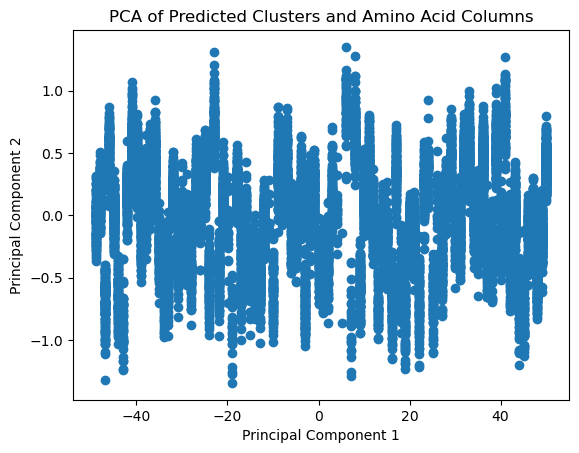

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract the columns for PCA
vectors_cols = ['Cluster'] + list(df.columns[3:83])
vectors = df[vectors_cols]

# Convert the DataFrame to a NumPy array
vectors = vectors.to_pandas().values

# Perform PCA
pca = PCA(n_components=2)
vectors = pca.fit_transform(vectors)

# Plot the results
plt.scatter(vectors[:, 0], vectors[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Predicted Clusters and Amino Acid Columns')
plt.show()

In [30]:
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

#Extract the columns for PCA
vectors_cols = ['Cluster'] + list(df.columns[3:83])
vectors = df[vectors_cols]

#Convert the DataFrame to a NumPy array
vectors = vectors.to_pandas().values

cluster_labels = df['Cluster'].to_pandas()

num_clusters = 100

# Perform PCA on the word vectors
pca = PCA(n_components=3)
vectors_pca = pca.fit_transform(vectors)

# Create a 3D scatter plot
trace = go.Scatter3d(
    x=vectors_pca[:, 0],
    y=vectors_pca[:, 1],
    z=vectors_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    title='Amino Acid Sequence Vectors - PCA'
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

fig.show()

Checkpoint 2: Saving the model

In [ ]:
from sklearn.cluster import KMeans
import joblib

joblib.dump(model, '/kaggle/working/checkpoint2_model.pkl')

Uncomment to load model:

In [ ]:
#import joblib

#model = joblib.load('/kaggle/working/checkpoint2_model.pkl')

Running the model on the other 1% of proteins that were ignored:

In [31]:
import cudf

# Create a cuDF DataFrame for predicting clusters
df_predict = cudf.DataFrame()
df_predict['sequence no'] = range(len(functional_pro)//100)
df_predict['amino acid sequence'] = cudf.Series([str(seq) for seq in functional_pro[len(functional_pro)//100:2*len(functional_pro)//100]])
df_predict['sequence length'] = df_predict['amino acid sequence'].str.len()

df_predict

,sequence no,amino acid sequence,sequence length
0,0,QPGAAPTPPGEHLTAWGSAHSPR,23
1,1,ASDSPEQRPHPQVSIWQPGAAPTPPGEHLTAWSSAHTLR,39
2,2,ASDSLGQHPHPQVSIWQPGTASTAPGDHLTA,31
3,3,ACDHMECHPHLQVSIRQPGTEFSNPR,26
4,4,QHGTRPLLPGEHLTTWESTLHPHVSI,26
...,...,...,...
12899,12899,IHYLTRERALLSDLAAFTLP,20
12900,12900,ATSSETPGRWRRRLVPVHTPHQKPAFHSCSNECNPFSEDTAPASRKTQ,48
12901,12901,HGASILLFVSVHCSLAFAYLALAGKS,26
12902,12902,CICVIEVHMEGLVCRNLLLCWGQMVLLPIFHLSLSLGPREALSPTG...,67


In [32]:
import cudf
import pandas as pd

percentages = [0.25, 0.5, 0.75, 1.0]

#Get the unique amino acids
amino_acids = sorted(set(''.join(df_predict['amino acid sequence'].to_arrow().to_pylist())))

#Iterate over each unique amino acid
for amino_acid in amino_acids:
    #Calculate the frequency of the amino acid for each percentage of each sequence
    for percentage in percentages:
        df_predict[f'{amino_acid}_{int(percentage*100)}%'] = df_predict['amino acid sequence'].to_pandas().apply(
            lambda sequence: sequence.count(amino_acid) / len(sequence[:int(len(sequence) * percentage)])
        )

In [33]:
df_predict

,sequence no,amino acid sequence,sequence length,A_25%,A_50%,A_75%,A_100%,C_25%,C_50%,C_75%,...,V_75%,V_100%,W_25%,W_50%,W_75%,W_100%,Y_25%,Y_50%,Y_75%,Y_100%
0,0,QPGAAPTPPGEHLTAWGSAHSPR,23,0.800000,0.363636,0.235294,0.173913,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.200000,0.090909,0.058824,0.043478,0.000000,0.000000,0.000000,0.000000
1,1,ASDSPEQRPHPQVSIWQPGAAPTPPGEHLTAWSSAHTLR,39,0.555556,0.263158,0.172414,0.128205,0.000000,0.000000,0.000000,...,0.034483,0.025641,0.222222,0.105263,0.068966,0.051282,0.000000,0.000000,0.000000,0.000000
2,2,ASDSLGQHPHPQVSIWQPGTASTAPGDHLTA,31,0.571429,0.266667,0.173913,0.129032,0.000000,0.000000,0.000000,...,0.043478,0.032258,0.142857,0.066667,0.043478,0.032258,0.000000,0.000000,0.000000,0.000000
3,3,ACDHMECHPHLQVSIRQPGTEFSNPR,26,0.166667,0.076923,0.052632,0.038462,0.333333,0.153846,0.105263,...,0.052632,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,QHGTRPLLPGEHLTTWESTLHPHVSI,26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.052632,0.038462,0.166667,0.076923,0.052632,0.038462,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12899,12899,IHYLTRERALLSDLAAFTLP,20,0.600000,0.300000,0.200000,0.150000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.100000,0.066667,0.050000
12900,12900,ATSSETPGRWRRRLVPVHTPHQKPAFHSCSNECNPFSEDTAPASRKTQ,48,0.333333,0.166667,0.111111,0.083333,0.166667,0.083333,0.055556,...,0.055556,0.041667,0.083333,0.041667,0.027778,0.020833,0.000000,0.000000,0.000000,0.000000
12901,12901,HGASILLFVSVHCSLAFAYLALAGKS,26,0.833333,0.384615,0.263158,0.192308,0.166667,0.076923,0.052632,...,0.105263,0.076923,0.000000,0.000000,0.000000,0.000000,0.166667,0.076923,0.052632,0.038462
12902,12902,CICVIEVHMEGLVCRNLLLCWGQMVLLPIFHLSLSLGPREALSPTG...,67,0.187500,0.090909,0.060000,0.044776,0.312500,0.151515,0.100000,...,0.100000,0.074627,0.062500,0.030303,0.020000,0.014925,0.000000,0.000000,0.000000,0.000000


In [35]:
#Create a new DataFrame with the amino acid columns
df_test = df_predict[df_predict.columns[3:83]]

#Convert the training data to a cuPy array
test_data = cp.asarray(df_test.values)

labels_predict = model.predict(test_data)
df_predict['Cluster'] = labels_predict

In [36]:
df_predict['Cluster'].value_counts()

69    497
99    349
31    289
81    269
28    268
     ... 
7      24
6      21
53     17
38     10
54      5
Name: Cluster, Length: 100, dtype: int32

A graph between clusters and PCA:

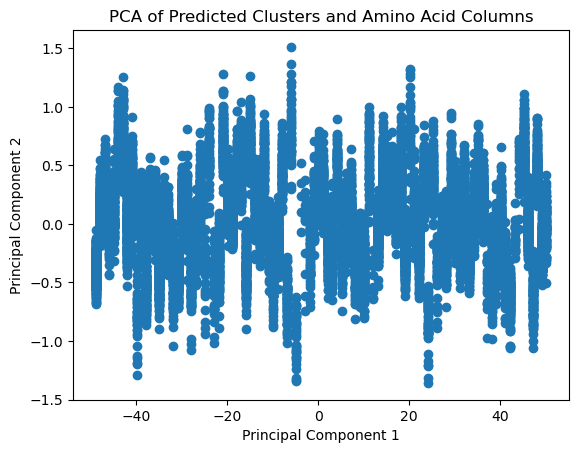

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Extract the columns for PCA
vectors_cols = ['Cluster'] + list(df_predict.columns[3:83])
vectors = df_predict[vectors_cols]

#Convert the DataFrame to a NumPy array
vectors = vectors.to_pandas().values

#Perform PCA
pca = PCA(n_components=2)
vectors = pca.fit_transform(vectors)

# Plot the results
plt.scatter(vectors[:, 0], vectors[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Predicted Clusters and Amino Acid Columns')
plt.show()

In [39]:
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

#Extract the columns for PCA
vectors_cols = ['Cluster'] + list(df_predict.columns[3:83])
vectors = df_predict[vectors_cols]

#Convert the DataFrame to a NumPy array
vectors = vectors.to_pandas().values

cluster_labels = df_predict['Cluster'].to_pandas()

num_clusters = 100

#Perform PCA on the word vectors
pca = PCA(n_components=3)
vectors_pca = pca.fit_transform(vectors)

#Create a 3D scatter plot
trace = go.Scatter3d(
    x=vectors_pca[:, 0],
    y=vectors_pca[:, 1],
    z=vectors_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    title='Amino Acid Sequence Vectors - PCA'
)

#Create the figure
fig = go.Figure(data=[trace], layout=layout)

fig.show()

This is a very rudimentary approach as I have not considered any structural data, or inferences from existing databases and models. The next task would be to compare this with an existing model, and analyse all chromosomes.

Note: Only 2% of Chromosome 1 is being used by the model. The number has been brought down to focus on changing aspects of the model.